👉This script is a work in progress and aims to provide functionality for extracting curricula information from PDF files and converting it into a graph format. Our
methods combine three innovations: 

1) using recent transformer models pretrained on text and fine-tuned for semantic similary; 

2) few-shot learning to improve domain-specific performance; and 

3) a pipeline to extract data from PDF files, convert it into a graph format, and enhances the graph to contain online resources related to each course.

👇 Import the necessary libraries:

In [18]:
#Environment: FAIR-OER(python3.8.18)
#LIBRARIES
import random
import pandas as pd
import ast
import pytz
import re
from datetime import datetime
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error
#import pdftotext
#from googletrans import Translator
#from langdetect import detect, LangDetectException
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from scipy.spatial.distance import cosine
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pyarrow
import pyarrow.parquet
from datasets import load_dataset
from datasets import Features, Value
from sentence_transformers import SentenceTransformer, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.similarity_functions import SimilarityFunction
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from rdflib import Graph, Namespace, URIRef, Literal, BNode
from rdflib.namespace import RDF, RDFS, XSD, DCTERMS, FOAF, DC, OWL
import rdflib
import urllib.parse
from urllib.parse import quote
import networkx as nx

In [13]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
4


In [14]:
# constant variables
metadata_dir = "/home/jovyan/Publication/fair_oer/05-Documentation/metadata.csv"
script = 'sbert_finetune_08-2024'
local_tz = pytz.timezone('Europe/Berlin')
local_time = datetime.now(local_tz).strftime('%Y%m%d')

In [6]:
def metadata_log(metadata_dir, output_dir, script, inputs_dir, functions):

  name =os.path.basename(output_dir)
  input = [os.path.basename(input_dir) for input_dir in inputs_dir]
  timestamp = datetime.now(local_tz).strftime('%y-%m-%d %H:%M:%S')

  metadata = {
      'name' :  name,
      'script' : script,
      'input' : input,
      'function' : functions,
      'timestamp' :  timestamp
  }

  with open(metadata_dir, 'a', newline='') as csvfile:
    fieldnames = ['name', 'script', 'input', 'function', 'timestamp']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writerow(metadata)

👇Use `pdftocsv` function to extract the course information from specified pages.

👉 Parameters:

```python
pdf_path (str): The path to the PDF file.
start (int): The starting page number to extract content from. 
end (int): The ending page number to extract content from.
header (int): The number of lines to skip from the top of each page. 
footer (int): The number of lines to skip from the bottom of each page.
keywords (dictionary): A dictionary where each key-value pair represents the start and end keywords of course information to extract.
```

In [ ]:
def pdftocsv(pdf_path, start=1, end=None, header=0, footer=0, keywords={}):
    # Paths
    text_path = pdf_path.replace('.pdf', '.txt')
    csv_path = pdf_path.replace('.pdf', '.csv')
    # Read PDF
    with open(pdf_path, 'rb') as pdf_file:
        pdf = pdftotext.PDF(pdf_file)
        end = end or len(pdf)
    # Write relevant PDF content to a text file
    with open(text_path, 'w', encoding='utf-8') as pdf_content:
        for page_number in range(start - 1, end):
            lines = pdf[page_number].splitlines()
            main_lines = lines[header:-footer or None]
            main_content = '\n'.join(main_lines)
            pdf_content.write(main_content + '\n')
    # Extract course information and save it as CSV
    with open(text_path, 'r') as file:
        content = file.read()
        data = {}
        max_length = 0
        for keyword_one, keyword_two in keywords.items():
            sections = content.split(keyword_one)[1:]
            matches = [section.split(keyword_two)[0] for section in sections]
            data[keyword_one] = matches
            max_length = max(max_length, len(matches))
        for key in data:
            while len(data[key]) < max_length:
                data[key].append('N/A')
        df = pd.DataFrame(data)
    df.to_csv(csv_path, index=False)
    return df

👉 We curated a dataset of course concepts from Technical University of Munich (TUM)'s module handbooks published by departments responsible for ESS education. Following Module handbooks [1] were downloaded for extracting course data using `pdftocsv` function:

- [Geodesy and Geoinformation B. Sc.](https://collab.dvb.bayern/pages/viewpage.action?pageId=73390039&preview=/73390039/73392000/Module-Catalog_BScGeodesyGeoinformation_EN_01122021.pdf)
- [Earth Oriented Space Science and Technology ESPACE M. Sc.](https://collab.dvb.bayern/pages/viewpage.action?pageId=73389806&preview=/73389806/73391596/ESPACE_ModuleHandbook_WS2019.pdf)
- [Cartography M. Sc.](https://cartographymaster.eu/wp-content/documents/CARTOGRAPHY_Module_Handbook.pdf)
- [Geodesy and Geoinformation M. Sc.](https://collab.dvb.bayern/pages/viewpage.action?pageId=73389896&preview=/73389896/73392890/Module-Catalog_MScGeodesyGeoinformation_EN_19102022.pdf)
- [Information Technologies for the Built Environment M. Sc.](https://collab.dvb.bayern/pages/viewpage.action?pageId=73389824&preview=/73389824/340755251/MSc-ITBE_Module-Catalog__20231219.pdf#Dokumente/Documents%E2%80%93M.Sc.ITBE-ModuleCatalog-updated19.12.2023)

👇The `data_summary` file contains information about module handbooks including parameters needed to call the `pdftocsv` function. The `pdftocsv` function is called for each row.

*[1] https://collab.dvb.bayern/display/TUMedschooloffice/For+Students+and+Prospective+Students*

In [ ]:
data_summary = pd.read_csv(R"B:\Publication\fair_oer\02-Data\00-Raw\TUM_metadata_text-scraping_20240908.csv")
for index, row in data_summary.iterrows():
    pdf_path = row['pdf_path']
    start = row['start']
    end = row['end']
    header = row['header']
    footer = row['footer']
    keywords = ast.literal_eval(row['keywords'])
    pdftocsv(pdf_path, start, end, header, footer, keywords)

👇String together the courses  by reading course lists (CSV files) and concatenating them into a single DataFrame.

In [ ]:
courses = pd.concat([pd.read_csv(pdf_path.replace('.pdf', '.csv')) for pdf_path in data_summary['pdf_path']], ignore_index=True)
courses.to_csv(R"B:\Publication\fair_oer\02-Data\01-Processed\TUM_aggregated_pdftotext_20240908.csv", index=False)

👉 Following steps were taken for cleaning extracted data before using them for semantic analysis:
1. First column was splited by delimiter `: ` into two columns. It was splited by left most delimiter `: ` to avoid splitting the course name. This step was done using excel.
2. Removing duplicates from the data. Since the data was extracted from different module handbooks, there were some duplicates in the data. Duplicates were removed using excel.
3. Removing thesis, workshops, internship, projects and seminars from the data. Since the thesis, workshops,internship, projects and seminars are not courses, they were removed from the data using excel.
4. Removing general courses such as language courses, soft skills courses, etc.
5. Translating German descriptions to English. This step was done using `googletrans` library and `DEtoEN` function 👇.
6. Normalizing the data by removing special characters, converting to lower case, and removing extra new lines. This step was done using `normalization` function 👇.
7. Merging columns containing information about a course content using `merge_columns` function 👇.

In [ ]:
def DEtoEN(csv_path):
    output_path = csv_path.replace('.csv', '_en.csv')
    df = pd.read_csv(csv_path)
    translator = Translator()
    for i in range(len(df)):
        for j in range(len(df.columns)):
            text = df.iat[i, j]
            if pd.notna(text):
                try:
                    lang = detect(text)
                except LangDetectException:
                    print(f"Cannot detect language for text: {text[:30]}...")
                    lang = None
                if lang == 'de':
                    df.iat[i, j] = translator.translate(text, src='de', dest='en').text
                else:
                    df.iat[i, j] = text
    df.to_csv(output_path, index=False)
    return df

In [ ]:
DEtoEN(R"B:\Publication\fair_oer\02-Data\01-Processed\TUM_aggregated_pdftotext_20240908.csv")

In [6]:
def normalization(csv_path):
    normalized_path = csv_path.replace('.csv', '_norm.csv')
    df = pd.read_csv(csv_path)

    df = df.applymap(lambda s: s.replace('\n', ' ').replace('\t', ' ') if type(s) == str else s)
    df = df.applymap(lambda s: s.lower() if type(s) == str else s)
    df = df.replace({R'[^\w\s]':''}, regex=True)

    df.to_csv(normalized_path, index=False)
    return df

In [ ]:
normalization(R'/home/jovyan/Publication/fair_oer/02-Data/01-Processed/OER_cleaned_aggregated_20240910.csv')

In [ ]:
def merge_columns(csv_path, column_list, prerequisite_column):
    merged_path = csv_path.replace('.csv', '_merged.csv')
    df = pd.read_csv(csv_path)
    df_merged = pd.DataFrame()
    df_merged['course'] = df.iloc[:, column_list].astype(str).apply('\n'.join, axis=1)
    df_merged['prerequisites'] = df.iloc[:, prerequisite_column]
    df_merged.to_csv(merged_path, index=False)
    return df_merged

In [ ]:
merge_columns(R'B:\Publications\FAIR OER\02-Data\01-Processed\courses_clean_en_norm.csv', [0, 2, 3], 1)

👉Construction of ground truths data

To evaluate and fine-tune our language models, we curated a ground truth dataset comprising course descriptions and corresponding OER. This dataset enables us to assess model performance by comparing its output to known correct mappings.

We employed web scraping techniques to extract detailed course information from the Massachusetts Institute of Technology's (MIT) OpenCourseWare (OCW) and subject catalog. The OCW provides free access to course materials and descriptions from MIT, while the subject catalog offers a comprehensive list of courses offered by the university. In this way, we aimed to gather a diverse set of course descriptions describing the same courses from two different sources.

MIT OCW is a web-based publication of virtually all MIT course content. OCW is open and available to the world and is a permanent MIT activity. The OCW site indexes course materials from various departments and makes them available to the public. 

First, we identified the target web pages containing the relevant course information. For the OCW data, we navigated to the Earth, Atmospheric, and Planetary Sciences department page and fetched the HTML content using Python's `selenium` library. We then parsed the HTML using `BeautifulSoup` to extract the course code, title, and URL for each course. 

Next, we visited each course's detailed page using the URLs obtained and applied a custom function `fetch_metadata` to extract comprehensive course details, including the course code, date, level, description, instructors, and topics. This function utilized `BeautifulSoup` to parse the HTML and locate the relevant elements based on their class names and tag structures. The extracted data was then compiled into a structured format and saved into a CSV file for further analysis.

In parallel, we accessed the MIT subject catalog and extracted similar data for comparison. This process was automated using Python scripts to ensure consistency and accuracy.

Finally, we manually compared the descriptions from both sources for a subset of courses. This comparison was documented in concise paragraphs to make sure that the course descriptions were similar and could be considered equivalent. By employing these web scraping and data extraction techniques, we were able to systematically gather and analyze a large volume of course information.

In our case, there is an imbalance in the classes, the odds of an OER **not** being directly linked to another course is much more prevalent. The metric that captures the trade-off between recall and specificity is the “Receiver Operating Characteristics” (ROC) curve.It shows the trade-off between recall and specificity as you change the cutoff value.The ROC curve can be used to produce the area underneath the curve (AUC) metric. The larger the value of AUC, the more effective the classifier. We use AUC metric to evaluate models in their zero-shot and few-shot learning capabilities. 

We used 63 courses coupled by their descriptions from MIT OCW and MIT subject catalog as ground truth data. The ground truth data was used to evaluate the performance of the model in zero-shot learning. 

Creation of the ground truth data set was done manually after the above step. 

In [ ]:
# zero-shot learning
model = SentenceTransformer('sentence-transformers/all-mpnet-v2')

input_dir = R"/home/jovyan/Publication/fair_oer/02-Data/01-Processed/MIT_augmented_normalization_20240829.csv"
ground_truth = load_dataset(
    'csv',
    data_files=input_dir,
    split='train'
)

similarity_score = []

for row in ground_truth:
    mit_embedding = model.encode(row['description-mit'])
    ocw_embedding = model.encode(row['description-ocw'])

    similarity = model.similarity(mit_embedding, ocw_embedding)

    similarity_score.append(similarity.item())

ground_truth = ground_truth.add_column("similarity_score", similarity_score)
output_dir = Rf"/home/jovyan/Publication/fair_oer/02-Data/02-Analyzed/pdftograph_pipeline_09-2024/MIT_prediction_mpnet_{local_time}.csv"
ground_truth.to_csv(output_dir)

In [10]:
model_directory = R"/home/jovyan/Publication/fair_oer/02-Data/02-Analyzed/sbert_finetune_08-2024/model_finetuned_B256_E107_2e-5_20240908"
checkpoints = [model_directory]

oer = pd.read_csv(R"/home/jovyan/Publication/fair_oer/02-Data/01-Processed/OER_normalized_aggregated_20240910.csv")
tum = pd.read_csv(R"/home/jovyan/Publication/fair_oer/02-Data/01-Processed/TUM_normalized_merged_20240910.csv")

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] 
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

for checkpoint in checkpoints:
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = AutoModel.from_pretrained(checkpoint)
    model.eval()
    oer_description = oer['all'].tolist()
    tum_description = tum['all'].tolist()
    
    oer_tokens = []
    tum_tokens = []
    for i in range(len(oer_description)):
        oer_tokens.append(tokenizer(oer_description[i], padding="max_length", truncation=True, max_length=512, return_tensors="pt"))
    for i in range(len(tum_description)):
        tum_tokens.append(tokenizer(tum_description[i], padding="max_length", truncation=True, max_length=512, return_tensors="pt"))
    
    oer_embeddings = []
    tum_embeddings = []
    for input in oer_tokens:
        with torch.no_grad():
            outputs = model(**input)
            oer_embeddings.append(outputs)
    for input in tum_tokens:
        with torch.no_grad():
            outputs = model(**input)
            tum_embeddings.append(outputs)
    
    oer_pooled_embeddings = []
    tum_pooled_embeddings = []
    for i, embeddings in enumerate(oer_embeddings):
        mean_pooled = mean_pooling(embeddings, oer_tokens[i]['attention_mask'])
        oer_pooled_embeddings.append(F.normalize(mean_pooled, p=2, dim=1))
    for i, embeddings in enumerate(tum_embeddings):
        mean_pooled = mean_pooling(embeddings, tum_tokens[i]['attention_mask'])
        tum_pooled_embeddings.append(F.normalize(mean_pooled, p=2, dim=1))
    
    similarity_scores = np.zeros((len(tum_pooled_embeddings), len(oer_pooled_embeddings)))
    for i, p in enumerate(tum_pooled_embeddings):
        for j, c in enumerate(oer_pooled_embeddings):
            p_expanded = p.squeeze()
            c_expanded = c.squeeze()
            similarity = F.cosine_similarity(p_expanded, c_expanded, dim=0)
            similarity_scores[i][j] = similarity.item()
            similarity_df = pd.DataFrame(similarity_scores)
            similarity_df.to_csv(rf'/home/jovyan/Publication/fair_oer/02-Data/02-Analyzed/pdftograph_pipeline_09-2024/FAIR_predictions_finetuned_{local_time}.csv', index=False)
    

In [8]:
similarity_df = pd.read_csv(R"/home/jovyan/Publication/fair_oer/02-Data/02-Analyzed/pdftograph_pipeline_09-2024/FAIR_predictions_finetuned_20240910.csv")
similarity_df

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,501
0,0.127180,0.253817,0.104192,0.253103,0.085621,0.201036,0.121364,0.022151,0.060271,0.148047,...,-0.014879,-0.075710,-0.029784,-0.067803,0.082679,0.102760,0.147464,0.135075,0.097593,0.050512
1,0.157763,0.031186,0.124431,0.236370,0.184746,0.034824,0.120879,0.037584,0.157171,0.179346,...,0.071126,0.061525,0.059768,0.027005,0.131401,0.107281,0.076222,0.051829,0.186478,0.097475
2,0.276023,0.281156,0.278351,0.409062,0.260908,0.220301,0.271356,0.241613,0.239219,0.283045,...,0.136920,0.094769,0.076827,0.071705,0.156651,0.181785,0.131538,0.103467,0.197885,0.170831
3,0.257262,0.195568,0.252551,0.487419,0.313430,0.240825,0.282357,0.174191,0.267206,0.323478,...,0.098193,0.023105,0.041829,0.033698,0.105523,0.099505,0.300389,0.276419,0.133387,0.092854
4,-0.001824,0.054411,0.038324,0.161375,0.036250,-0.037895,-0.005245,0.021747,0.051391,0.044339,...,-0.025474,-0.062787,-0.043603,-0.029068,0.113479,0.162016,0.221820,0.201170,0.109955,0.081903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,0.294113,0.105372,0.295749,0.406632,0.250452,0.039916,0.236470,0.077110,0.158487,0.259509,...,0.145915,0.112824,0.190687,0.135327,0.158794,0.155095,0.105478,0.088838,0.183981,0.113246
220,0.296972,0.140112,0.307908,0.109274,0.191292,0.113006,0.163475,0.012067,0.266800,0.242739,...,0.064650,-0.004536,0.097552,0.051398,0.233663,0.182706,0.090676,0.077728,0.197843,0.089784
221,0.276063,0.148664,0.287162,0.203207,0.263469,0.078530,0.260955,0.039252,0.166501,0.229894,...,0.162020,0.103214,0.188332,0.151102,0.257595,0.175972,0.111314,0.099857,0.160760,0.106965
222,0.049822,0.229558,0.079033,0.098663,0.037642,0.033313,0.056811,-0.012300,-0.017008,0.000508,...,0.074348,0.047815,0.077407,0.060561,0.104047,0.103537,0.002352,-0.010027,0.098405,0.048973


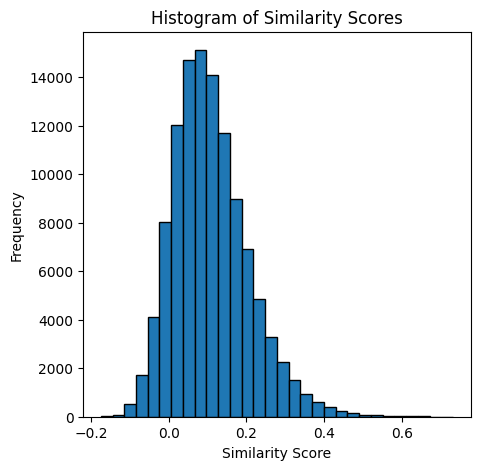

90th Percentile: 0.24
95th Percentile: 0.29
Skewness of the data: 0.8192411893356992
Kurtosis of the data: 1.362071564292922


In [33]:
similarity_df = pd.read_csv(R"/home/jovyan/Publication/fair_oer/02-Data/02-Analyzed/pdftograph_pipeline_09-2024/FAIR_predictions_finetuned_20240910.csv")

similarity_scores = similarity_df.values.flatten()

similarity_scores = similarity_scores[~np.isnan(similarity_scores)]

plt.figure(figsize=(5, 5))
plt.hist(similarity_scores, bins=30, edgecolor='black')
plt.title('Histogram of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

percentile_90 = np.percentile(similarity_scores, 90)
percentile_95 = np.percentile(similarity_scores, 95)
print(f'90th Percentile: {percentile_90:.2f}')
print(f'95th Percentile: {percentile_95:.2f}')


data_skewness = skew(similarity_scores)
print("Skewness of the data:", data_skewness)
data_kurtosis = kurtosis(similarity_scores)
print("Kurtosis of the data:", data_kurtosis)


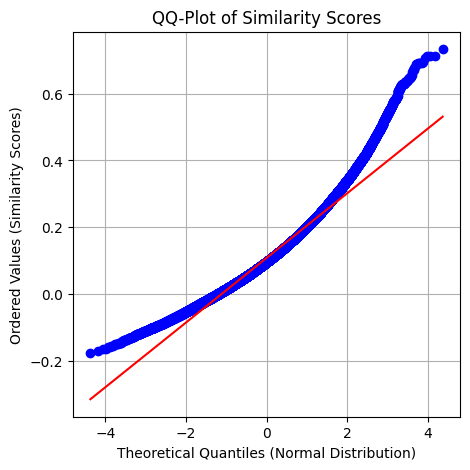

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))
stats.probplot(similarity_scores, dist="norm", plot=ax)
ax.get_lines()[1].set_color('red')
ax.set_title('QQ-Plot of Similarity Scores')
ax.set_ylabel('Ordered Values (Similarity Scores)')
ax.set_xlabel('Theoretical Quantiles (Normal Distribution)')
plt.grid(True)
plt.show()


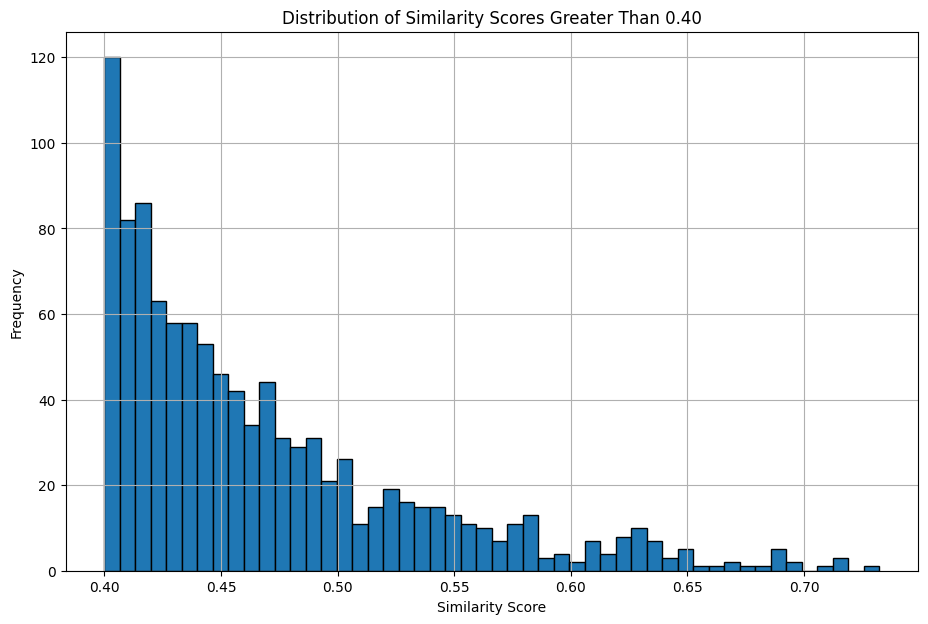

The number of similarity scores greater than 0.4 is: 1051


In [8]:
filtered_scores = similarity_scores[similarity_scores > 0.40]

plt.figure(figsize=(11, 7))
plt.hist(filtered_scores, bins=50, edgecolor='black')
plt.title('Distribution of Similarity Scores Greater Than 0.40')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

count_greater_than_03 = len(filtered_scores)
print(f'The number of similarity scores greater than 0.4 is: {count_greater_than_03}')

In [9]:
flattened_scores = data.values.flatten()
percentile_99_dot_5 = np.percentile(flattened_scores, 99.5)
filtered_data = data.where(data >= percentile_99_dot_5)
remaining_values = np.count_nonzero(~np.isnan(filtered_data.values))
print(f"Total values remaining above the 99.5 th percentile: {remaining_values}")


Total values remaining above the 99.5 th percentile: 563


In [20]:
similarity_scores = df.values.flatten()

high_threshold = np.percentile(similarity_scores, 99.5)

high_similarity_pairs = similarity_scores[similarity_scores >= high_threshold]

print(f"99.5 th percentile threshold: {high_threshold}")
print(f"Number of pairs with similarity >= {high_threshold}: {len(high_similarity_pairs)}")

99.5 th percentile threshold: 0.44305625781416885
Number of pairs with similarity >= 0.44305625781416885: 563


In [ ]:
predictions = pd.read_csv(R"/home/jovyan/Publication/fair_oer/02-Data/02-Analyzed/pdftograph_pipeline_09-2024/FAIR_predictions_finetuned_20240910.csv")

In [ ]:
threshold_top_0_5 = predictions.stack().quantile(0.995)
print(f"Threshold for top 0.5% similarity scores: {threshold_top_0_5}")

predictions_above_threshold = predictions[predictions >= threshold_top_0_5]

predictions_below_threshold = predictions[predictions < threshold_top_0_5]

def select_random_samples(df, num_samples, seed=None):
    if seed is not None:
        np.random.seed(seed)

    non_nan_indices = np.argwhere(~np.isnan(df.values))
    
    if len(non_nan_indices) < num_samples:
        raise ValueError(f"Not enough non-NaN values to sample {num_samples} from.")

    random_selection = non_nan_indices[np.random.choice(len(non_nan_indices), num_samples, replace=False)]
    
    result = [(row, col, df.iat[row, col]) for row, col in random_selection]
    
    return result

In [50]:
samples_above = select_random_samples(predictions_above_threshold, num_samples=80, seed=73)
print("Random samples from top 0.5%:", samples_above)

Random samples from top 0.5%: [(15, 72, 0.6381771564483643), (33, 94, 0.4715985655784607), (139, 147, 0.5099937319755554), (124, 113, 0.5336015820503235), (3, 181, 0.4808806777000427), (41, 144, 0.460252970457077), (166, 106, 0.5333847999572754), (91, 38, 0.4534977078437805), (117, 38, 0.5406864881515503), (76, 25, 0.4650867581367492), (126, 106, 0.4552122950553894), (25, 157, 0.5460373759269714), (166, 81, 0.5358250141143799), (212, 390, 0.4552224576473236), (117, 45, 0.5236362218856812), (35, 299, 0.5276044011116028), (212, 302, 0.4861910343170166), (212, 394, 0.45307058095932), (82, 40, 0.4915402829647064), (200, 482, 0.477481335401535), (42, 70, 0.5405413508415222), (128, 147, 0.5899401903152466), (134, 143, 0.4574954807758331), (31, 487, 0.6345797777175903), (9, 487, 0.4872188568115234), (119, 26, 0.6283942461013794), (188, 120, 0.5025622844696045), (207, 5, 0.4544304609298706), (7, 25, 0.4691043496131897), (38, 489, 0.4676196575164795), (162, 38, 0.4767686724662781), (125, 106, 0

In [49]:
samples_below = select_random_samples(predictions_below_threshold, num_samples=80, seed=73)
print("Random samples from the rest:", samples_below)

Random samples from the rest: [(159, 347, 0.0477454848587513), (85, 405, 0.0184831544756889), (166, 205, 0.2197196781635284), (12, 380, -0.0350987091660499), (138, 264, 0.049195572733879), (192, 407, 0.0495187044143676), (63, 327, 0.0550516322255134), (10, 418, 0.2376965284347534), (207, 156, 0.0541002675890922), (14, 383, -0.0334649644792079), (135, 394, -0.0332212448120117), (158, 245, 0.2644177079200744), (185, 462, 0.073736272752285), (125, 270, 0.0273501463234424), (83, 445, 0.2247719168663025), (164, 97, 0.3146499097347259), (134, 322, 0.2481474876403808), (73, 304, 0.1816271245479583), (140, 424, 0.2402980178594589), (138, 403, 0.0867294073104858), (163, 344, 0.0561560131609439), (101, 341, -0.0116161946207284), (148, 151, 0.0938085988163948), (85, 308, 0.1763985455036163), (22, 239, 0.0231606550514698), (85, 214, 0.0760432630777359), (174, 198, 0.0550969839096069), (166, 259, 0.0682038217782974), (11, 130, 0.2466367185115814), (158, 344, 0.0168388038873672), (80, 118, 0.0300724

In [11]:
tum_df = pd.read_csv('/home/jovyan/Publication/fair_oer/02-Data/01-Processed/TUM_requirments_manual_20240914.csv')
oer_df = pd.read_csv('/home/jovyan/Publication/fair_oer/02-Data/01-Processed/OER_raw_aggregated_20240908.csv')
predictions_df = pd.read_csv('/home/jovyan/Publication/fair_oer/02-Data/02-Analyzed/pdftograph_pipeline_09-2024/FAIR_predictions_finetuned_20240910.csv')

print("TUM Dataset Columns:", tum_df.columns)
print("OER Dataset Columns:", oer_df.columns)
print("Predictions Dataset Columns:", predictions_df.columns)

TUM Dataset Columns: Index(['title', 'index', 'prerequisite-1', 'prerequisite-2', 'prerequisite-3',
       'prerequisite-4', 'prerequisite-5', 'prerequisite-6', 'prerequisite-7',
       'prerequisite-8', 'prerequisite-9', 'prerequisites', 'content',
       'objectievs', 'all', 'description'],
      dtype='object')
OER Dataset Columns: Index(['Title', 'index', 'all', 'Description', 'Publisher', 'Year', 'Source',
       'Language', 'License', 'Copyright owner', 'Requirement', 'Intro',
       'Beginner', 'Intermediate', 'Advanced',
       'Author/Instructor/Email/Phone/Contact page', 'Keywords'],
      dtype='object')
Predictions Dataset Columns: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '492', '493', '494', '495', '496', '497', '498', '499', '500', '501'],
      dtype='object', length=502)


In [15]:
g = Graph()

ETKG = Namespace("http://etkg.nfdi4earth.de#")
SCHEMA = Namespace("http://schema.org/")

g.bind("schema", SCHEMA)
g.bind("etkg", ETKG)
g.bind("xsd", XSD)
g.bind("owl", OWL)
g.bind("rdfs", RDFS)

for course_num, tum_row in tum_df.iterrows():
    safe_course_num = urllib.parse.quote(str(course_num)) 
    course_uri = ETKG[f"course_{safe_course_num}"] 



    g.add((course_uri, RDF.type, SCHEMA.Course))
    g.add((course_uri, SCHEMA.name, Literal(tum_row['title'], datatype=XSD.string)))
    g.add((course_uri, SCHEMA.description, Literal(tum_row['description'], datatype=XSD.string)))

    for i in range(1, 10):
        prerequisite_col = f"prerequisite-{i}"
        prereq_value = tum_row[prerequisite_col]

        if not pd.isna(prereq_value) and prereq_value!='`':
            safe_prereq_value = urllib.parse.quote(str(int(prereq_value)))
            prereq_uri = ETKG[f"course_{safe_prereq_value}"]  
            g.add((course_uri, SCHEMA.coursePrerequisite, prereq_uri))

    similarity_row = predictions_df.iloc[course_num]
    
    for column_num, similarity_score in similarity_row.items():
        if similarity_score >= 0.44305625781416885:
            oer_uri = ETKG[f"oer_{column_num}"]
            blank_node = BNode()

            g.add((course_uri, SCHEMA.material, blank_node))
            g.add((blank_node, ETKG.oer, oer_uri))
            g.add((blank_node, ETKG.hasSimilarityScore, Literal(similarity_score, datatype=XSD.float)))

            oer_row = oer_df.iloc[int(column_num)]
            g.add((oer_uri, RDF.type, SCHEMA.LearningResource))
            g.add((oer_uri, SCHEMA.name, Literal(oer_row['Title'], datatype=XSD.string)))
            g.add((oer_uri, SCHEMA.description, Literal(oer_row['Description'], datatype=XSD.string)))
            g.add((oer_uri, SCHEMA.url, URIRef(oer_row['Source'])))
            
g.serialize(destination=f"/home/jovyan/Publication/fair_oer/02-Data/02-Analyzed/pdftograph_pipeline_09-2024/fair_serialized_graph_{local_time}.ttl", format="turtle")


<Graph identifier=N7240013ad6ea49fb92aa30eff2327ab7 (<class 'rdflib.graph.Graph'>)>

In [16]:
g = Graph()
g.parse(R'/home/jovyan/Publication/fair_oer/02-Data/02-Analyzed/pdftograph_pipeline_09-2024/fair_serialized_graph_20240916.ttl', format="ttl")

print(f"Number of triples: {len(g)}")

Number of triples: 3447
